# Early Detection of Cardiac Arrest - Classification of ECG Signals for Arrhythmia Disease Prediction

**What is Cardiac Arrest ?**

*Cardiac arrest is a sudden loss of heart function, breathing, and consciousness. It's an "electrical" problem where the heart's intricate electrical system, which dictates the heartbeat, malfunctions. This is different from a heart attack, which is a "plumbing" problem caused by blocked arteries. Early detection is critical because the chances of survival decrease dramatically with each passing minute.*

**How to detect Cardiac Arrest?**

*Biometric signals, especially the Electrocardiogram (ECG), are key to predicting cardiac arrest. An ECG records the electrical activity of the heart, and subtle changes in its pattern can be precursors to a life-threatening event. The goal is to train a model that can recognize these subtle, pre-arrest patterns in ECG data.*

**What this model does ?**

*This model classifies individual heartbeats into different arrhythmia categories using the MIT-BIH Arrhythmia Database. The 5 categories are:*

*N: Normal beat*

*L: Left bundle branch block beat*

*R: Right bundle branch block beat*

*A: Atrial premature beat*

*V: Ventricular ectopic beat*

*Massachusetts Institute of Technology (MIT) - Beth Israel Hospital (BIH) Database Links:*

*1. Training --> https://www.kaggle.com/datasets/taejoongyoon/mitbit-arrhythmia-database/data*

*2. Testing --> https://www.kaggle.com/datasets/shayanfazeli/heartbeat*


**How this relates to cardiac arrest ?**

*Certain arrhythmias, particularly Ventricular Tachycardia and Ventricular Fibrillation (which fall under the 'Ventricular' category), are often immediate precursors to sudden cardiac arrest.*

*This model detecs Ventricular Ectopic Arrhythmias. These are abnormal heartbeats originating from the lower chambers (the ventricles) of the heart. A frequent occurrence of these "V" beats, especially in specific patterns, is a major risk factor and can be a direct precursor to life-threatening conditions like Ventricular Tachycardia, which often leads to Sudden Cardiac Arrest.*

*Thus, the classification of beat types is a critical component of an early detection system for Cardiac Arrest.*

\



---

# 1. Input Setup and Data Preparation

 1.1 Imports

In [ ]:
import numpy as np    # for array and matrix operations
import pandas as pd   # for operations using dataframes
import os   # for operations involving the google drive

import matplotlib.pyplot as plt   # for visualizations
import csv    # for comma separated valued files
import pywt   # for denoise signals thorugh wavelet transforms (reqd. for ECG data)

from scipy import stats   # for statistical operations
from sklearn.model_selection import train_test_split    # to split dataset for training and testing
from sklearn.utils import resample    # for handling imbalanced datasets (downsampling a majority class or upsampling a minority class)

from keras.models import Sequential   # for building my neural network architectures
from keras.layers import Conv1D     # for processing sequential data (signals in this case)
from keras.layers import AvgPool1D    # for downsampling input
from keras.layers import Flatten    #  for flatening multidimensional input to 1D vector
from keras.layers import Dense    # fully connected neural network layer for matrix-vector multiplication
from keras.layers import Dropout    # regularization technique to prevent overfitting
from keras.layers import Softmax    # to convert output into probability distribution
from keras.optimizers import Adam   # optimizer algorithm to minimize loss function
from keras.utils import to_categorical    # to convet integer labels to encoded vectors
from keras import regularizers    #  to prevent overfitting

1.2 Assigning custom settings to matplotlib properties

In [ ]:
# %matplotlib inline    # not reqd for google colab (used this in jupyter for inline plot outputs)
plt.rcParams["figure.figsize"] = (15,5)     # size for all figues
plt.rcParams['lines.linewidth'] = 1     # width for plot lines
plt.rcParams['lines.color'] = 'b'     # blue color for plot lines
plt.rcParams['axes.grid'] = True    # grids for plot axes

1.3 Importing the dataset

In [ ]:
# to manually mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Google Drive path for dataset folder
path = '/content/drive/MyDrive/Datasets/mitbih_database/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.4 Variables

In [ ]:
# Globals
window_size    = 180    # no. of samples to consider before peak in ECG signal
# maximum_counting = 10000
classes        = ['N', 'L', 'R', 'A', 'V']    # for diff. types of heartbeats
n_classes      = len(classes)     # no of classes = 5
count_classes  = [0]*n_classes     # to count no. of instances of heartbeat classes processed
X, y           = [], []     # x - stores extract ECG data; y - stores corresponding class labels

1.5 List & separate .csv (signals) vs .txt (annotations)

In [ ]:
# read all files and sort them alphabetically in a list
filenames   = sorted(os.listdir(path))

# add files into lists after sorting into .csv and .txt
records     = [path+f for f in filenames if f.endswith('.csv')]
annotations = [path+f for f in filenames if f.endswith('.txt')]

---

# 2. Data Preprocessing

2.1 Denoise function for noise reduction by performing Wavelet Transforms

In [ ]:
def denoise(data):

    w        = pywt.Wavelet('sym4')     # selects sym4 wavelet for transformation
    maxlev   = pywt.dwt_max_level(len(data), w.dec_len)   # calculating highest possible decomposition level
    coeffs   = pywt.wavedec(data, 'sym4', level=maxlev)     # for removing noise based on the threshold value
    thresh   = 0.04 * max(abs(c) for c in coeffs[1])    # threshold for filtering noise (small coefficients)

    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], thresh)

    return pywt.waverec(coeffs, 'sym4')

2.2 Loop through each record and annotation pair

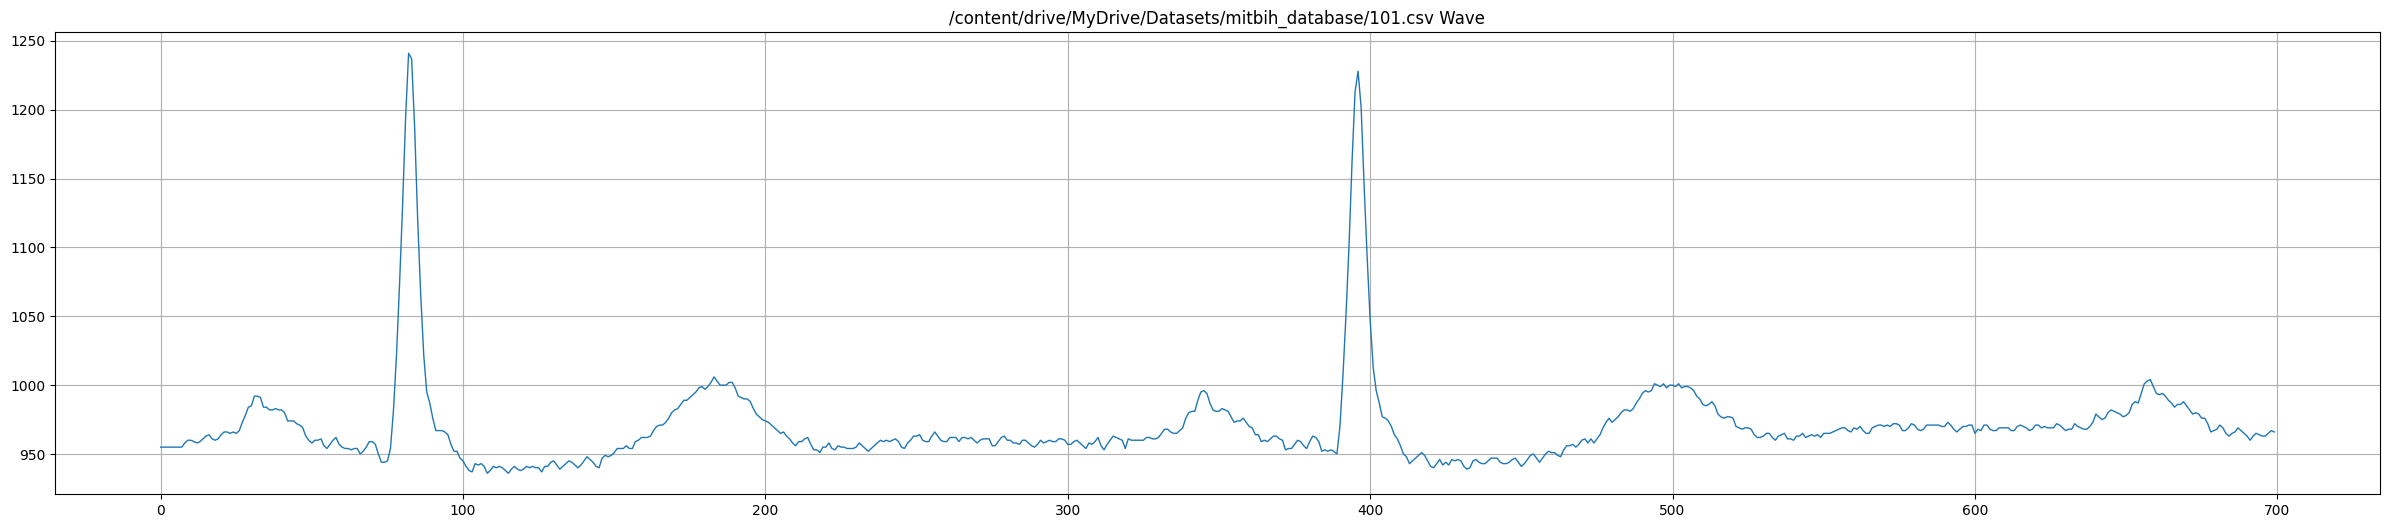

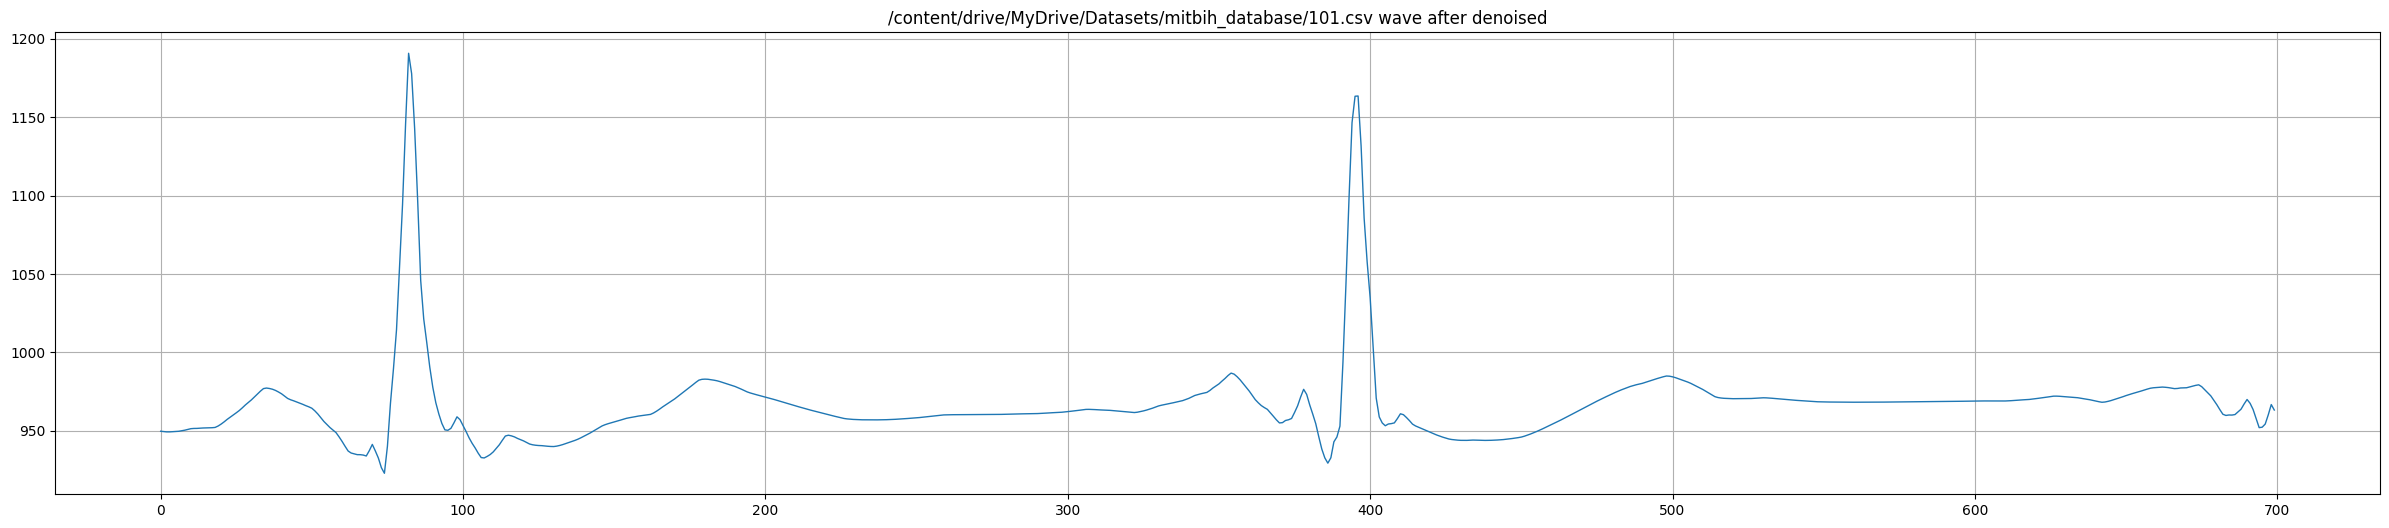

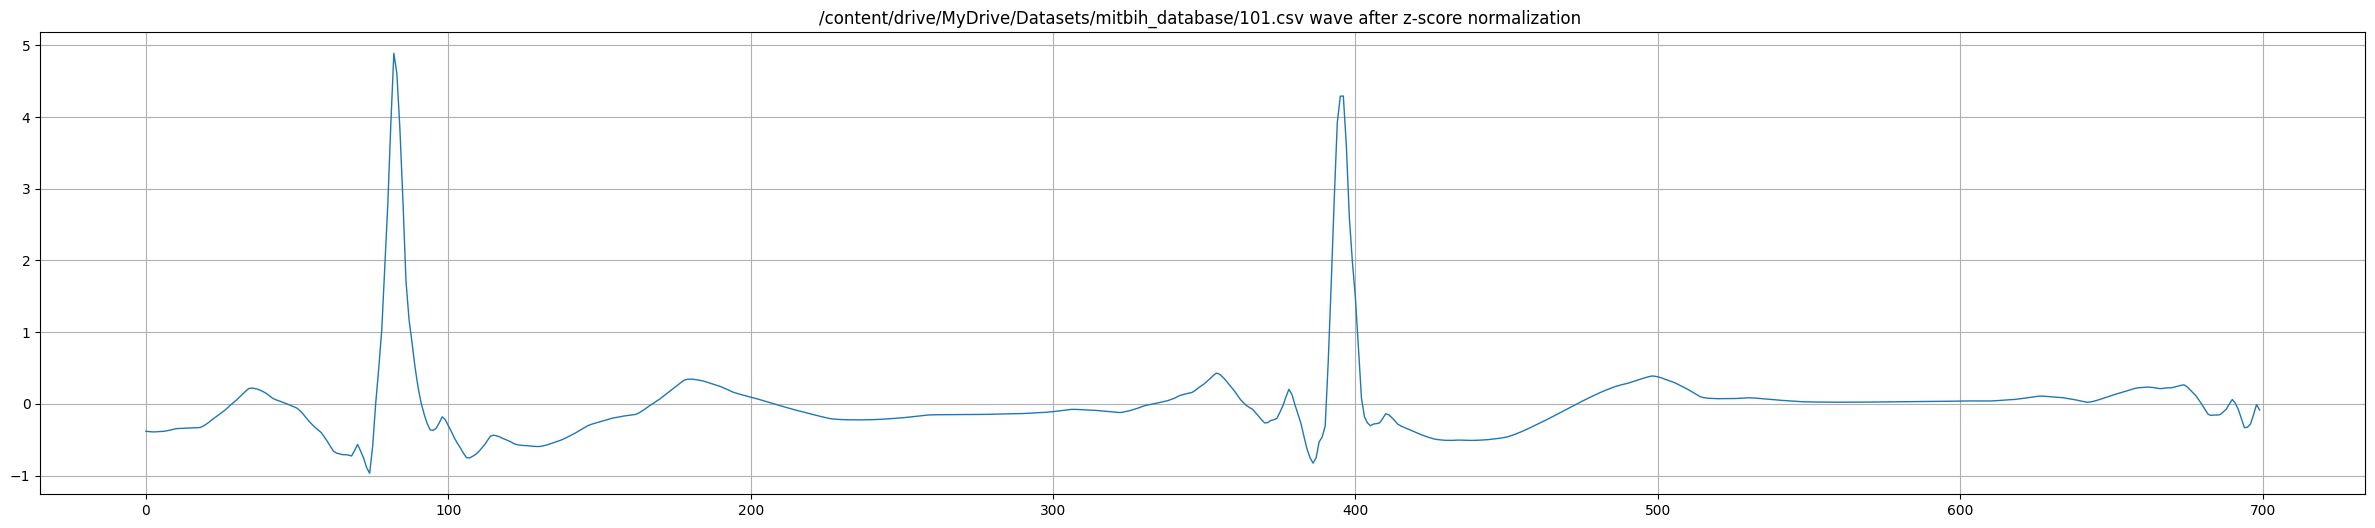

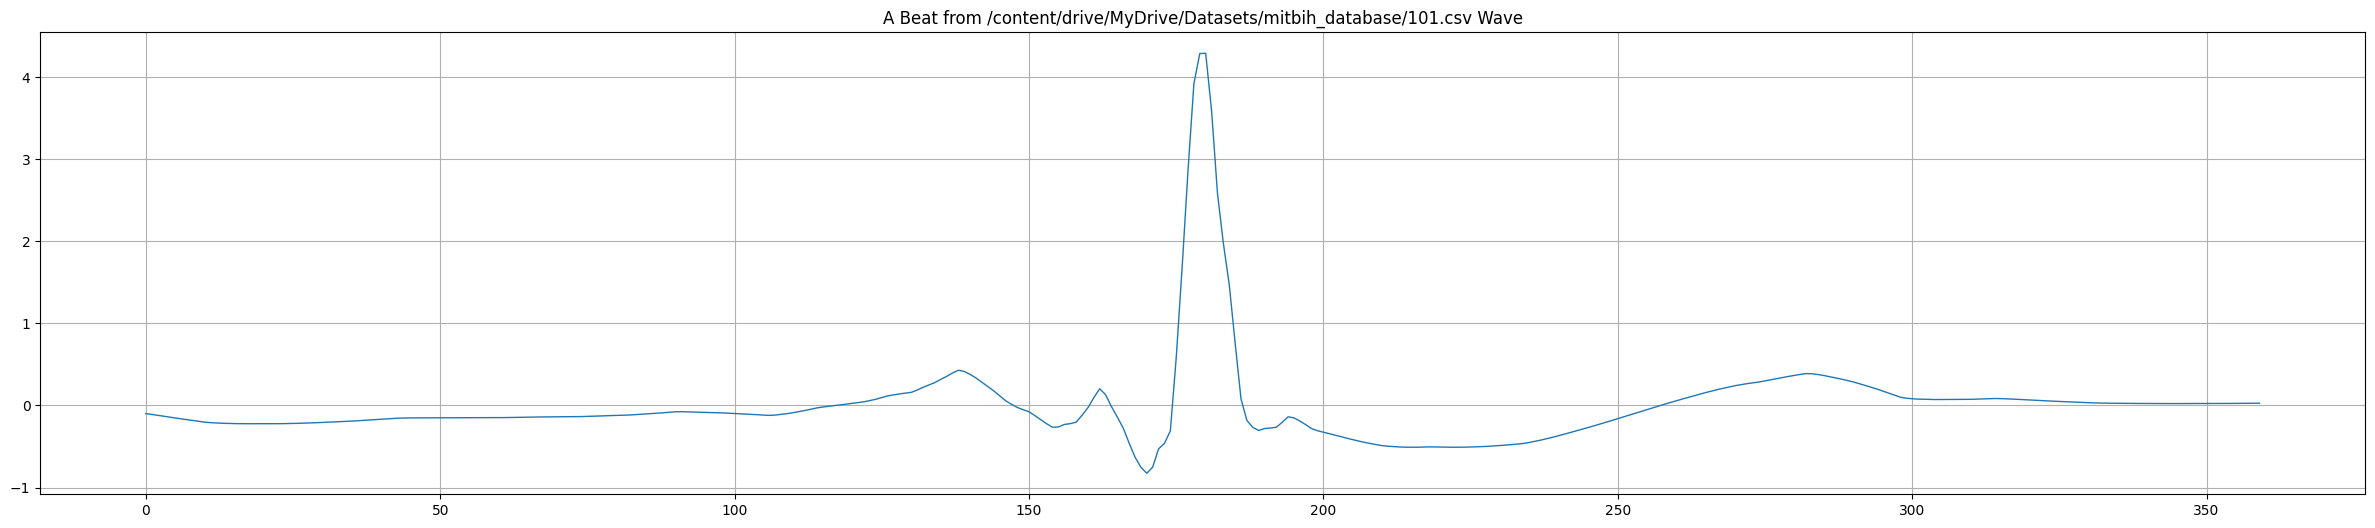

In [ ]:
for rec_path, ann_path in zip(records, annotations):

    # load raw ECG samples into signals
    signals = []

    with open(rec_path, 'r') as f:
        reader = csv.reader(f)    # reader obj to iterate over lines in the csv file
        next(reader)    # skip header of csv file
        for row in reader:
            signals.append(int(row[1]))

    # Plot an example to the signals
    if rec_path == records[1]:
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise(signals)    # denoise function to remove noise

    # Plot an example to the signals
    if rec_path == records[1]:
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)   # normalization performed on the signals

    # Plot an example to the signals
    if rec_path == records[1]:
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # reading and processing annotations
    example_beat_printed = False
    with open(ann_path, 'r') as f:
        lines = f.readlines()[1:]   # read all lines and slice to exclude 1st line
    for line in lines:
        parts = list(filter(None, line.split()))    # split line into parts based on whitespace and remove empty strings (multi-spaces)
        pos   = int(parts[1])     # extracts and converts R-peak position into an integer
        label = parts[2]    # extracts label for heartbeat
        if label not in classes:    # this cross-checks the label with heartbeat classes and if not found, skips to next line
            continue
        idx = classes.index(label)    # storing index of label
        count_classes[idx] += 1   # counting how many times each heartbeat type have been processed

        # this if condition checks if the R-peak position is far enough from the beginning and end of the signal.
        # if satisfied, it extracts a complete window before and after the peak.
        if window_size <= pos < len(signals) - window_size:
            beat = signals[pos-window_size:pos+window_size]   # this extracts a segment that represesnts the heartbeat.

            # Plot an example beat
            if rec_path == records[1] and not example_beat_printed:
                plt.title("A Beat from " + records[1] + " Wave")
                plt.plot(beat)
                plt.show()
                example_beat_printed = True

            X.append(beat)   # adds heartbeat segment to the list
            y.append(idx)   # adds index of the hearbeat class to the list

2.3 Convert to arrays & inspect for data shape

In [ ]:
X = np.array(X)   # shape: (total_beats, 360)
y = np.array(y)   # shape: (total_beats,)
print("Collected heartbeats:", X.shape, "Labels:", y.shape)

Collected heartbeats: (100012, 360) Labels: (100012,)


2.4 Plotting class distribution.

Before balancing:
 label
0    75011
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


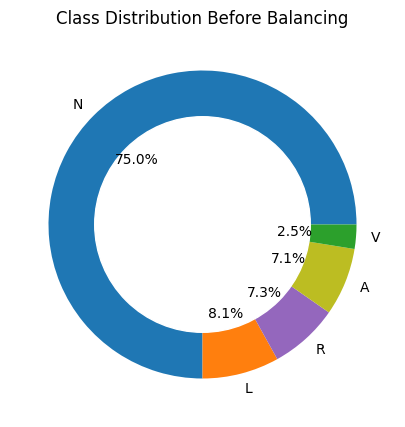

In [ ]:
# converting preprocessed heartbeat data and class labels into dataframes
df = pd.DataFrame(X)
df['label'] = y

# plotting the current class distribution
per_class_before = df['label'].value_counts()     # counts how many instances of each unique value exist in the label column
print("Before balancing:\n", per_class_before)

# pie chart to represent the distribution
plt.figure(figsize=(10, 5))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class_before,
        labels=['N', 'L', 'R', 'A', 'V'],
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'],
        autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Class Distribution Before Balancing")
plt.show()

2.5 Balancing the class distribution

In [ ]:
# spliting dataframe into dictionary of smaller of dataframes for each class label
dfs = {lbl: df[df.label == i] for i, lbl in enumerate(classes)}

# target sample size for each class after balancing
target_n = min(len(dfs['N']), 5000)  # capping normal beats at 5000
target_n = 5000                     # force cap to 5000 for each class after normal.

# down/up-sampling each class to meet target sample size
balanced_dfs = []
for i, lbl in enumerate(classes):
    cls_df = dfs[lbl]
    if len(cls_df) > target_n:
        cls_df = cls_df.sample(n=target_n, random_state=42)   # down-sampling by selecting random samples till target sample size is reached.
    else:
        cls_df = resample(cls_df, replace=True, n_samples=target_n, random_state=42)      # up-sampling by resampling with replacements until target sample size is reached.
    balanced_dfs.append(cls_df)

# random state = 42 ensure that the sampling is reproducible.

# concatenate and convert balanced_dfs list to dataframe & reshuffling the dataframe and resetting index to a new default index.
balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

2.6 Plotting the balanced class distribution

After balancing:
 label
1    5000
4    5000
2    5000
0    5000
3    5000
Name: count, dtype: int64


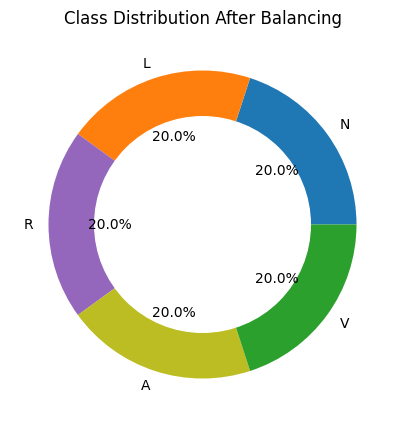

In [ ]:
# to recount how many instances of each unique value exist in the label column
per_class_after = balanced_df['label'].value_counts()
print("After balancing:\n", per_class_after)

# pie chart to plot balanced class distribution
plt.figure(figsize=(10, 5))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class_after,
        labels=['N', 'L', 'R', 'A', 'V'],
        colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'],
        autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Class Distribution After Balancing")
plt.show()

2.7 separating balanced data back into values and labels

In [ ]:
# Split back to X / y
X_bal = balanced_df.drop('label', axis=1).values    # removing label column to get the values only as an array
y_bal = balanced_df['label'].values   # extracting only the label column as an array

print("After balancing:", np.bincount(y_bal), "=> each class =", target_n)   # bincount calculates number of non-negative integer value in y_bal

After balancing: [5000 5000 5000 5000 5000] => each class = 5000


---

# 3. Building the model

3.1 Spliting dataset into training and testing sets

In [ ]:
# spliting dataset - 80% for training and 20% for testing
train_df, test_df = train_test_split(balanced_df, test_size=0.2)

# Separating features(values) and labels for both train and test dataset
train_x = train_df.iloc[:,:-1].values.reshape(-1, 360, 1)
train_y = to_categorical(train_df.iloc[:,-1])

test_x  = test_df.iloc[:,:-1].values.reshape(-1, 360, 1)
test_y  = to_categorical(test_df.iloc[:,-1])

print(np.shape(train_y), np.shape(test_y))      # training value and label dataset
print(np.shape(train_x), np.shape(test_x))    # testing value and label dataset

(20000, 5) (5000, 5)
(20000, 360, 1) (5000, 360, 1)


3.2 Building the 1D Convolutional Neural Network (CNN) for time-series data (1D ECG Signals)

In [ ]:
# creating the layers of neural network
model = Sequential([
  Conv1D(16,13,padding='same',activation='relu', input_shape=(360,1)),
  AvgPool1D(3,2),
  Conv1D(32,15,padding='same',activation='relu'),
  AvgPool1D(3,2),
  Conv1D(64,17,padding='same',activation='relu'),
  AvgPool1D(3,2),
  Conv1D(128,19,padding='same',activation='relu'),
  AvgPool1D(3,2),   # giving the pooling layer window_size=3 and sliding_step=2 to reduce number of parameters and computations in the network
  Flatten(),    # flatens the output from pooling layers into 1D vector
  Dropout(0.5),   # setting 50% input units to 0 to reduce overfitting
  Dense(35, kernel_regularizer=regularizers.l2(1e-4)),    # first fully connected layer = 35 neuraons
  Dense(5,  kernel_regularizer=regularizers.l2(1e-4)),    # second fully connected layer = 5 output classes
  Softmax()     # activation function for output layer - converts output scores into a probability distribution over 5 classes.
])

# table for architecture of the neural network
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 360, 16)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 179, 16)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 179, 32)        │         7,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 89, 32)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 89, 64)         │        34,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 44, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44, 128)        │       155,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 21, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2688)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 35)             │        94,115 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,887 (1.12 MB)

 Trainable params: 292,887 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

3.3 Compiling model for training

In [ ]:
# configuring the model for classification
model.compile(loss='categorical_crossentropy',  # categorical_crossentropy for multi-class classification
              optimizer=Adam(),   # Adam - optimization algorithm to update model's weight during training
              metrics=['accuracy'])

3.4 Trainig the model

In [ ]:
# this model will run through 60 epochs for 36 samples per gradient update
history = model.fit(train_x, train_y,
                    batch_size=36, epochs=60,
                    validation_data=(test_x, test_y))

# the output history object is plotted beloq for loss convergence and accuracy

Epoch 1/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6566 - loss: 0.8830 - val_accuracy: 0.8568 - val_loss: 0.4286
Epoch 2/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8531 - loss: 0.4376 - val_accuracy: 0.8816 - val_loss: 0.3600
Epoch 3/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8772 - loss: 0.3588 - val_accuracy: 0.9094 - val_loss: 0.2802
Epoch 4/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9020 - loss: 0.2977 - val_accuracy: 0.9196 - val_loss: 0.2549
Epoch 5/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9112 - loss: 0.2638 - val_accuracy: 0.9236 - val_loss: 0.2402
Epoch 6/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9222 - loss: 0.2424 - val_accuracy: 0.9170 - val_loss: 0.2648
Epoch 7/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9288 - loss: 0.2267 - val_accuracy: 0.9316 - val_loss: 0.2215
Epoch 8/60
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9330 - loss: 0.2109 - val_accuracy: 

---

# 4. Evaluation

4.1 Plotting for loss convergence

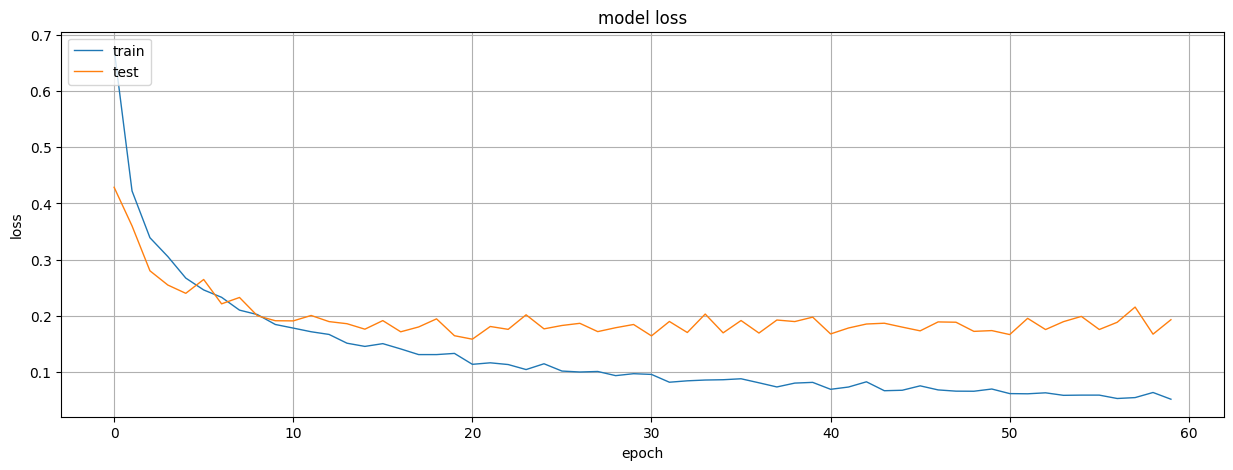

In [ ]:
# to summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

4.2 Plotting for accuracy

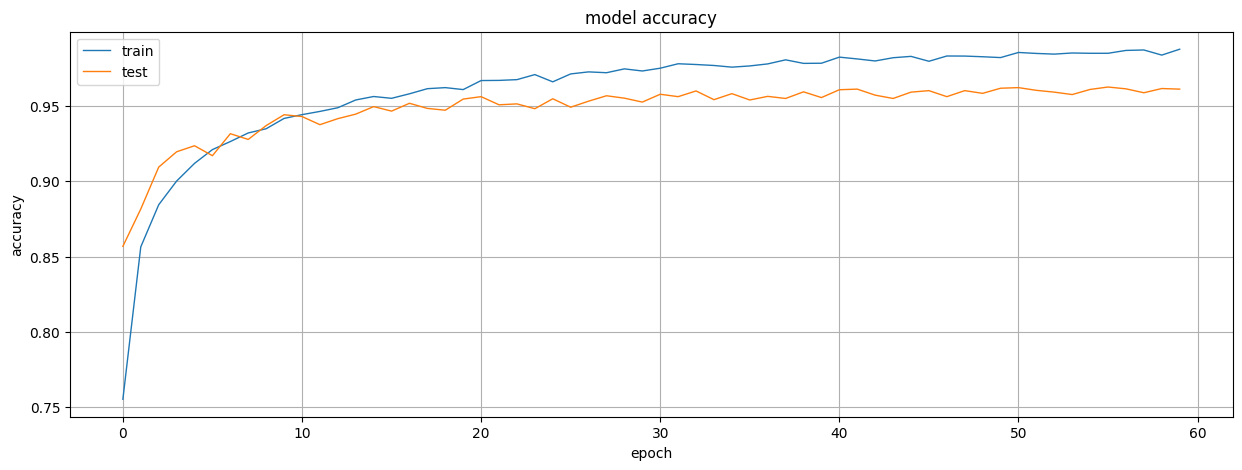

In [ ]:
# t0 summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

4.3 Evaluating the model for Loss and Accuracy

In [ ]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

acc_score = score[1]*100
print('Final Accuracy Score: ',round(acc_score,2),'%')

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9632 - loss: 0.1769
Test Loss: 0.1933613419532776
Test accuracy: 0.9611999988555908
Final Accuracy Score:  96.12 %


---

# 5. Saving the model to google drive

In [ ]:
# model.save('arrhythmia_cnn.h5')

In [ ]:
# saving model at custom google drive folder
save_path = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System'
model.save(os.path.join(save_path, 'arrhythmia_cnn.h5'))

---

# 6. Testing

6.1 Pre-requisite Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, csv, time
import numpy as np
import pywt
from scipy import stats
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


6.2 load trained model

In [ ]:
model_path = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/arrhythmia_cnn.h5'
model = load_model(model_path)
print("Model loaded. Input shape:", model.input_shape)

Model loaded. Input shape: (None, 360, 1)


6.3 Re‐defined preprocessing (matching the training)

In [ ]:
window_size = 180   # samples before & after R-peak
classes     = ['N','L','R','A','V']

def denoise(sig):
    w     = pywt.Wavelet('sym4')
    maxlev= pywt.dwt_max_level(len(sig), w.dec_len)
    coeffs= pywt.wavedec(sig, 'sym4', level=maxlev)
    thresh= 0.04 * max(abs(c) for c in coeffs[1])
    for i in range(1,len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], thresh)
    return pywt.waverec(coeffs, 'sym4')

6.4 helper function to process a long ECG array in sliding windows

In [ ]:
def sliding_inference(ecg_signal, step=50, alert_thresh=0.7):
    n = len(ecg_signal)
    alerts = []
    for center in range(window_size, n-window_size, step):
        window = ecg_signal[center-window_size:center+window_size]
        # denoise + normalize
        w = denoise(window)
        w = stats.zscore(w)
        # reshape for model: (1,360,1)
        inp = w.reshape(1, len(w), 1)
        probs = model.predict(inp, verbose=0)[0]
        # check ventricular class probability
        if probs[4] > alert_thresh:
            t_sec = center / 360.0   # if sampling at 360Hz → seconds
            alerts.append((t_sec, probs[4]))
    return alerts

6.5 testing the model by simulating on a different ECG dataset

In [ ]:
ecg_file = '/content/drive/MyDrive/Internships/IIITg/Cardiac Arrest Early Detection System/mitbih_test.csv/mitbih_test.csv'
signal = []
with open(ecg_file) as f:
    rdr = csv.reader(f)
    next(rdr)
    for row in rdr:
        signal.append(float(row[1]))
signal = np.array(signal)

alerts = sliding_inference(signal, step=50, alert_thresh=0.8)

if alerts:
    print(f"⚠️ {len(alerts)} alert(s) triggered:")
    for t, p in alerts:
        print(f" • at {t:.1f}s → P(ventricular) = {p:.2f}")
else:
    print("✅ No dangerous events detected.")

⚠️ 74 alert(s) triggered:
 • at 0.6s → P(ventricular) = 0.88
 • at 3.3s → P(ventricular) = 0.98
 • at 3.6s → P(ventricular) = 0.98
 • at 3.8s → P(ventricular) = 0.92
 • at 4.4s → P(ventricular) = 1.00
 • at 5.2s → P(ventricular) = 0.87
 • at 5.9s → P(ventricular) = 0.83
 • at 7.2s → P(ventricular) = 0.90
 • at 7.7s → P(ventricular) = 0.94
 • at 8.3s → P(ventricular) = 0.95
 • at 8.4s → P(ventricular) = 0.99
 • at 9.7s → P(ventricular) = 0.85
 • at 10.1s → P(ventricular) = 0.93
 • at 10.4s → P(ventricular) = 0.90
 • at 12.0s → P(ventricular) = 0.92
 • at 13.8s → P(ventricular) = 0.81
 • at 14.5s → P(ventricular) = 1.00
 • at 16.2s → P(ventricular) = 0.98
 • at 17.0s → P(ventricular) = 0.80
 • at 17.2s → P(ventricular) = 0.95
 • at 17.6s → P(ventricular) = 0.99
 • at 17.9s → P(ventricular) = 0.98
 • at 18.0s → P(ventricular) = 0.94
 • at 19.2s → P(ventricular) = 0.88
 • at 20.2s → P(ventricular) = 1.00
 • at 21.1s → P(ventricular) = 0.82
 • at 22.2s → P(ventricular) = 0.93
 • at 22.6s → 

6.6 Ploting to visualize where alerts occured

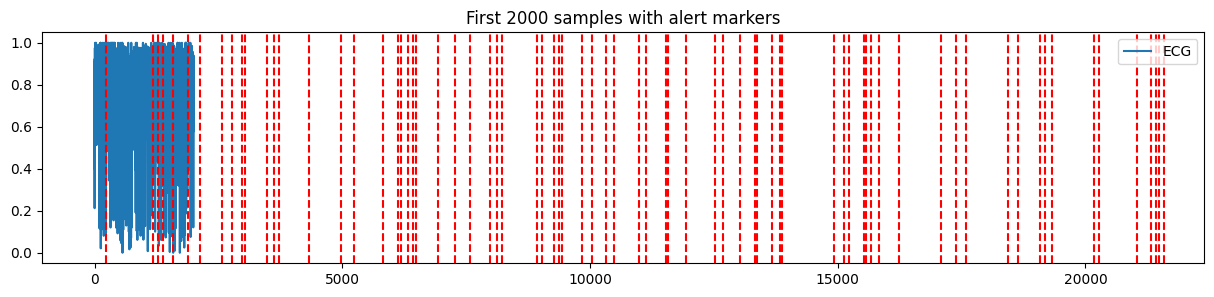

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(signal[:2000], label='ECG')
for t, _ in alerts:
    idx = int(t * 360)
    plt.axvline(idx, color='red', linestyle='--')
plt.legend(); plt.title("First 2000 samples with alert markers"); plt.show()